#### Import Modules

In [148]:
import pandas as pd
import numpy as np
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.lines as mlines

from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from statsmodels.sandbox.regression.predstd import wls_prediction_std


data = pd.read_csv("training_data.csv")

#### What are the unique conditions?

In [30]:
data['condition'].unique()

array(['atrial_fib', 'chronic_kidney', 'pulmonary', 'depression',
       'diabetes', 'ischemia', 'asthma', 'hyperlip', 'hypertension',
       'arthritis', 'psychotic', 'stroke'], dtype=object)

#### How many conditions are there?

In [31]:
len(data['condition'].unique())

12

#### How many years of data do we have?

In [32]:
data['year'].unique()

array([2017, 2016, 2015], dtype=int64)

In [131]:
data.columns

Index(['state', 'condition', 'year', 'prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other',
       'current_cost', 'last_year_cost'],
      dtype='object')

# EDA

In [157]:
xdat = data['last_year_cost']
xdat = sm.add_constant(xdat)
relationship = sm.OLS(data['current_cost'],xdat)
relationshipresult = relationship.fit()

In [160]:
relationshipresult.params

const             686.530114
last_year_cost      1.037881
dtype: float64

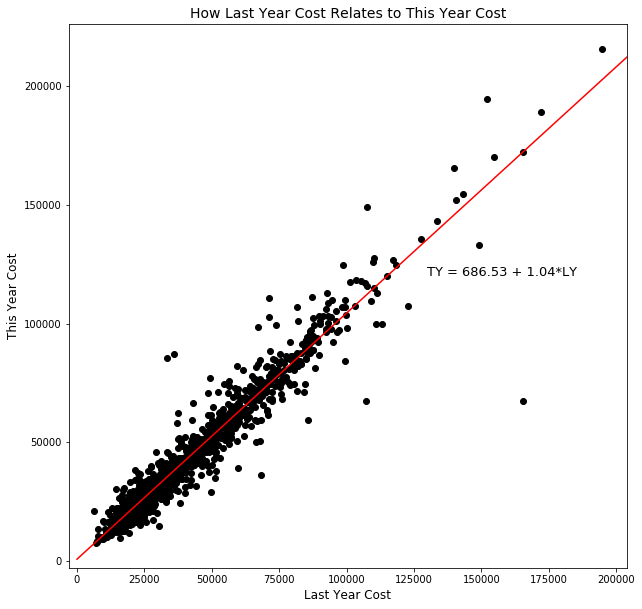

In [176]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(data['last_year_cost'], data['current_cost'], c='black')
#fig = plt.figure(figsize = (10,10))
#plt.scatter(data['last_year_cost'],data['current_cost'])
line = mlines.Line2D([0, 300000], [relationshipresult.params[0], relationshipresult.params[0]+300000*relationshipresult.params[1]], color='red')
plt.ylabel('This Year Cost',fontsize = 12)
plt.xlabel('Last Year Cost', fontsize = 12)
plt.title('How Last Year Cost Relates to This Year Cost',fontsize=14)
ax.add_line(line)
ax.text(130000, 120000, 'TY = {} + {}*LY'.format(str(round(relationshipresult.params[0],2)),str(round(relationshipresult.params[1],2))), fontsize=13)
plt.show()

#### Create dataset

In [33]:
#potentially create region?
#create 12 variables for type of condition
binaries = pd.get_dummies(data['condition'])
newdata = pd.merge(data, binaries, left_index=True, right_index=True)

In [34]:
newdata.columns

Index(['state', 'condition', 'year', 'prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other',
       'current_cost', 'last_year_cost', 'arthritis', 'asthma', 'atrial_fib',
       'chronic_kidney', 'depression', 'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke'],
      dtype='object')

In [35]:
finaldata = newdata[['prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other',
       'current_cost', 'last_year_cost', 'arthritis', 'asthma', 'atrial_fib',
       'chronic_kidney', 'depression', 'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke']]

In [36]:
x_data = finaldata[['prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other', 'last_year_cost',
       'arthritis', 'asthma', 'atrial_fib','chronic_kidney', 'depression',
        'diabetes', 'hyperlip', 'hypertension',
       'ischemia', 'psychotic', 'pulmonary', 'stroke']]
y_data = data.loc[:,"current_cost"]

In [206]:
corrdata = finaldata[['prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other', 'last_year_cost','current_cost']]

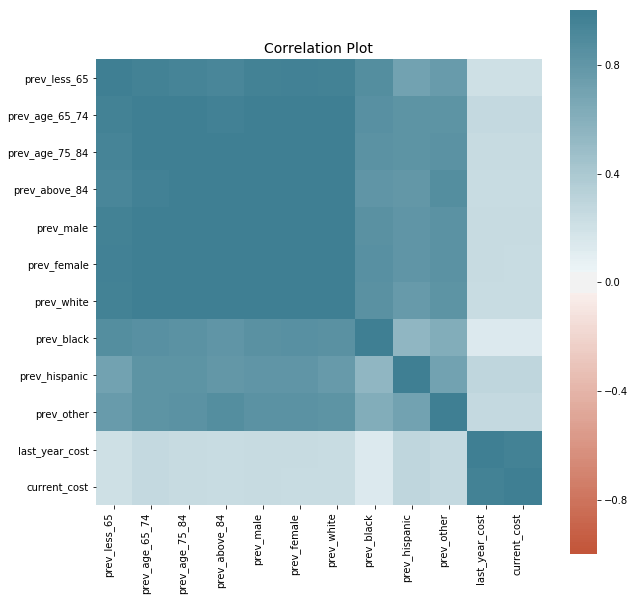

In [212]:
# Step 1 - Make a scatter plot with square markers, set column names as labels

# def heatmap(x, y, size):
#     fig, ax = plt.subplots(figsize=(10,10))
    
#     # Mapping from column names to integer coordinates
#     x_labels = [v for v in sorted(x.unique())]
#     y_labels = [v for v in sorted(y.unique())]
#     x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
#     y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
#     size_scale = 500
    
#     n_colors = 256 # Use 256 colors for the diverging color palette
#     palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
#     color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

#     def value_to_color(val):
#         val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
#         ind = int(val_position * (n_colors - 1)) # target index in the color palette
#         return palette[ind]

#     ax.scatter(
#         x=x.map(x_to_num),
#         y=y.map(y_to_num),
#         s=size * size_scale,
#         c= palette, # Vector of square color values, mapped to color palette
#         marker='s'
#     )
    
#     # Show column labels on the axes
#     ax.set_xticks([x_to_num[v] for v in x_labels])
#     ax.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
#     ax.set_yticks([y_to_num[v] for v in y_labels])
#     ax.set_yticklabels(y_labels)
#     ax.grid(False, 'major')
#     ax.grid(True, 'minor')
#     ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
#     ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
#     ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
#     ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    

# corr = corrdata.corr()
# corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
# corr.columns = ['x', 'y', 'value']
# heatmap(
#     x=corr['x'],
#     y=corr['y'],
#     size=corr['value'].abs()
# )

corr = corrdata.corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)
plt.title("Correlation Plot",fontsize=14);


#### Create test and training datasets

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size = .3, random_state = 100)

# Linear Regression

In [38]:
Xtrain = sm.add_constant(x_train)
Xtest = sm.add_constant(x_test)
olstrainmodel = sm.OLS(y_train,Xtrain)

In [39]:
olstrainresult = olstrainmodel.fit()

In [40]:
print(olstrainresult.summary())

                            OLS Regression Results                            
Dep. Variable:           current_cost   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     822.5
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               0.00
Time:                        14:46:24   Log-Likelihood:                -11616.
No. Observations:                1150   AIC:                         2.328e+04
Df Residuals:                    1127   BIC:                         2.339e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4285.2293    591.180      7.

In [41]:
testpred = olstrainresult.predict(Xtest)

#### MAE on Test Set

In [42]:
np.abs(testpred - y_test).mean()

3554.2014831916686

#### RMSE on Test Set

In [43]:
np.sqrt(np.mean((testpred - y_test)**2))

6222.150810763095

#### Create Prediction Dataset for 2018

In [52]:
newdata2 = pd.read_csv("aggregations/aggregations/df_state_2017.csv")

In [53]:
dataofinterest = newdata2[['nppes_provider_state', 'beneficiary_age_less_65_total',
       'beneficiary_age_65_74_total', 'beneficiary_age_75_84_total',
       'beneficiary_age_greater_84_total', 'beneficiary_male_total',
       'beneficiary_female_total','beneficiary_race_white_total',
       'beneficiary_race_black_total','beneficiary_race_hispanic_total',
       'beneficiary_race_other_total']]

In [54]:
dataofinterest.rename(columns={'nppes_provider_state':'state', 'beneficiary_age_less_65_total':'prev_less_65',
       'beneficiary_age_65_74_total':'prev_age_65_74', 'beneficiary_age_75_84_total':'prev_age_75_84',
       'beneficiary_age_greater_84_total':'prev_above_84', 'beneficiary_male_total':'prev_male',
       'beneficiary_female_total':'prev_female','beneficiary_race_white_total':'prev_white',
       'beneficiary_race_black_total':'prev_black','beneficiary_race_hispanic_total':'prev_hispanic',
       'beneficiary_race_other_total':'prev_other'},inplace = True)

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [55]:
twosev_data = newdata[newdata['year']==2017]

In [56]:
twosev_data.drop(columns=['condition', 'year', 'prev_less_65', 'prev_age_65_74',
       'prev_age_75_84', 'prev_above_84', 'prev_male', 'prev_female',
       'prev_white', 'prev_black', 'prev_hispanic', 'prev_other','last_year_cost'],inplace = True)

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
twosev_data.rename(columns={"current_cost": "last_year_cost"},inplace = True)


c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [58]:
predtwoeightdataprep = pd.merge(dataofinterest, twosev_data, how='inner', left_on='state', right_on='state')

In [59]:
predtwoeightdata = predtwoeightdataprep[['prev_less_65', 'prev_age_65_74', 'prev_age_75_84',
       'prev_above_84', 'prev_male', 'prev_female', 'prev_white', 'prev_black',
       'prev_hispanic', 'prev_other', 'last_year_cost', 'arthritis', 'asthma',
       'atrial_fib', 'chronic_kidney', 'depression', 'diabetes', 'hyperlip',
       'hypertension', 'ischemia', 'psychotic', 'pulmonary', 'stroke']]

# Predictions

In [60]:
newX = sm.add_constant(predtwoeightdata)

In [61]:
twoeightpred = olstrainresult.predict(newX)

In [70]:
def transform_exog_to_model(fit, exog):
    transform=True
    self=fit

    # The following is lifted straight from statsmodels.base.model.Results.predict()
    if transform and hasattr(self.model, 'formula') and exog is not None:
        from patsy import dmatrix
        exog = dmatrix(self.model.data.orig_exog.design_info.builder,
                       exog)

    if exog is not None:
        exog = np.asarray(exog)
        if exog.ndim == 1 and (self.model.exog.ndim == 1 or
                               self.model.exog.shape[1] == 1):
            exog = exog[:, None]
        exog = np.atleast_2d(exog)  # needed in count model shape[1]

    # end lifted code
    return exog

transformed_exog = transform_exog_to_model(olstrainresult, newX)
prstd2, iv_l2, iv_u2 = wls_prediction_std(olstrainresult, newX, weights=[1])

In [92]:
newvalues = np.concatenate((np.array(iv_l2).reshape((len(iv_l2),1)),np.array(twoeightpred).reshape((len(twoeightpred),1)),np.array(iv_u2).reshape((len(iv_u2),1))),axis=1)

# Rebuild Dataset

In [94]:
predtwoeightdataprep.columns

Index(['state', 'prev_less_65', 'prev_age_65_74', 'prev_age_75_84',
       'prev_above_84', 'prev_male', 'prev_female', 'prev_white', 'prev_black',
       'prev_hispanic', 'prev_other', 'last_year_cost', 'arthritis', 'asthma',
       'atrial_fib', 'chronic_kidney', 'depression', 'diabetes', 'hyperlip',
       'hypertension', 'ischemia', 'psychotic', 'pulmonary', 'stroke'],
      dtype='object')

In [95]:
twoeightdata = predtwoeightdataprep[['state','arthritis', 'asthma',
       'atrial_fib', 'chronic_kidney', 'depression', 'diabetes', 'hyperlip',
       'hypertension', 'ischemia', 'psychotic', 'pulmonary', 'stroke']]

In [100]:
twoeightdata.loc[twoeightdata.arthritis==1,'condition'] = 'arthritis'
twoeightdata.loc[twoeightdata.asthma==1,'condition'] = 'asthma'
twoeightdata.loc[twoeightdata.atrial_fib==1,'condition'] = 'atrial_fib'
twoeightdata.loc[twoeightdata.chronic_kidney==1,'condition'] = 'chronic_kidney'
twoeightdata.loc[twoeightdata.depression==1,'condition'] = 'depression'
twoeightdata.loc[twoeightdata.diabetes==1,'condition'] = 'diabetes'
twoeightdata.loc[twoeightdata.hyperlip==1,'condition'] = 'hyperlip'
twoeightdata.loc[twoeightdata.hypertension==1,'condition'] = 'hypertension'
twoeightdata.loc[twoeightdata.ischemia==1,'condition'] = 'ischemia'
twoeightdata.loc[twoeightdata.psychotic==1,'condition'] = 'psychotic'
twoeightdata.loc[twoeightdata.pulmonary==1,'condition'] = 'pulmonary'
twoeightdata.loc[twoeightdata.stroke==1,'condition'] = 'stroke'

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [104]:
twoeightdata.drop(columns=['atrial_fib', 'chronic_kidney', 'pulmonary', 'depression',
       'diabetes', 'ischemia', 'asthma', 'hyperlip', 'hypertension',
       'arthritis', 'psychotic', 'stroke'],inplace = True)

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
twoeightdata['year']=[2018]*len(twoeightdata)

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [113]:
twoeightdata['current_cost']=newvalues[:,1]

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [117]:
twoeightdata['lower_bound']=newvalues[:,0]
twoeightdata['upper_bound']=newvalues[:,2]

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [119]:
otherdata = data[['state','condition','year','current_cost']]

In [177]:
otherdata["lower_bound"] = otherdata['current_cost']
otherdata["upper_bound"] = otherdata['current_cost']

c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\camer\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [178]:
finaldataset = pd.concat([twoeightdata, otherdata], axis=0)

In [179]:
finaldataset.to_csv("finaldataset.csv",index=False)